In [105]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from numpy.random import normal

from muldoon.met_timeseries import MetTimeseries
from muldoon.utils import modified_lorentzian, fit_vortex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# Create time-series
time = np.linspace(-10, 10, 1000)
baseline = 0.
slope = 1.
t0 = 0.
DeltaP = 1.
Gamma = 0.5
profile = modified_lorentzian(time, baseline, slope, t0, DeltaP, Gamma) + normal(scale=slope/20., size=len(time))
mt = MetTimeseries(time, profile)

0.053591706314163816
True


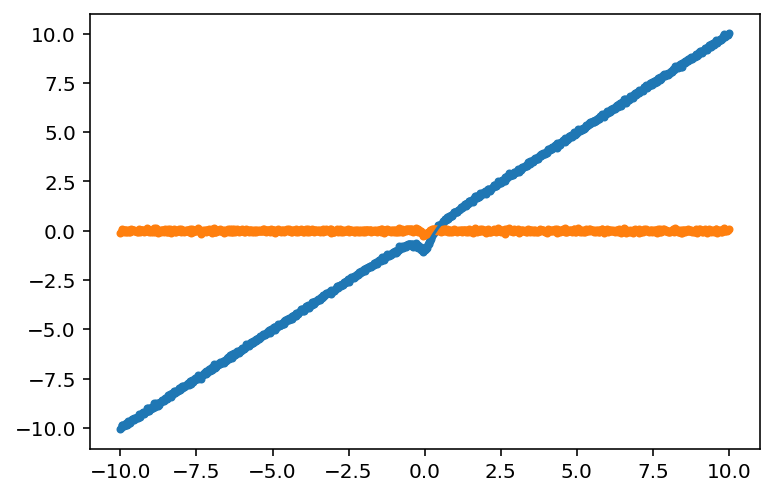

In [86]:
# Detrend
window_size = Gamma
detrended_pressure = mt.detrend_pressure_timeseries(window_size)
print(np.std(mt.detrended_pressure))
print(np.isclose(np.std(mt.detrended_pressure), 0.1, atol=0.1))

plt.scatter(mt.time, mt.pressure, marker='.')
plt.scatter(mt.time, mt.detrended_pressure, marker='.')
plt.plot(mt.time, mt.pressure_trend)

In [87]:
# Test time-series write-out
write_str = mt.write_out_detrended_timeseries(test_mode=True)
print(write_str);

# time, pressure
-10, -0.0930123
-9.97998, -0.0458268
-9.95996, 0.0784261
-9.93994, 0.0589695
-9.91992, 0.0127151
-9.8999, -0.0101026
-9.87988, -0.0467754
-9.85986, 0.0160223
-9.83984, 0.0457499
-9.81982, 0.045565
-9.7998, -0.0753448
-9.77978, -0.0746834
-9.75976, -0.0399088
-9.73974, 0.0547805
-9.71972, -0.0455777
-9.6997, 0.0100262
-9.67968, -0.0835103
-9.65966, 0.0612388
-9.63964, -0.0145778
-9.61962, 0.0600215
-9.5996, 0.0433219
-9.57958, 0.0531514
-9.55956, -0.0165647
-9.53954, 0.0289853
-9.51952, 0.00393584
-9.4995, 0.00125375
-9.47948, -0.0215638
-9.45946, -0.0573869
-9.43944, 0.000249038
-9.41942, -0.0668898
-9.3994, 0.0833926
-9.37938, -0.0390792
-9.35936, -0.0908319
-9.33934, -0.00323914
-9.31932, 0.0168655
-9.2993, 0.0103825
-9.27928, 0.0214973
-9.25926, -0.011914
-9.23924, 0.058813
-9.21922, -0.0623042
-9.1992, 0.0184129
-9.17918, -0.0393205
-9.15916, -0.0214001
-9.13914, 0.12103
-9.11912, -0.000366625
-9.0991, -0.0367525
-9.07908, 0.0899844
-9.05906, -0.0827072
-9.03904, 0

In [18]:
from scipy.stats import mode
print(mt.time[1:] - mt.time[0:-1])
print(mode(mt.time[1:] - mt.time[0:-1]).mode[0])

[0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002
 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002
 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002
 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002
 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002
 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002
 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002
 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002
 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002
 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002
 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002
 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002
 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002
 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002
 0.02002002 0.02002002 0.02002002 0.02002002 0.02002002 0.0200

8.787865871942492 0.03003003003003002 0.040040040040040026
0.03003003003003002


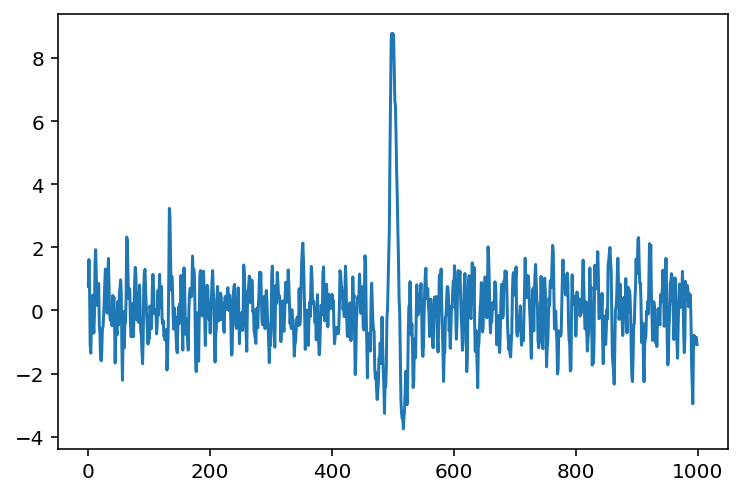

In [88]:
# plt.plot(mt.time, profile)
conv = mt.apply_lorentzian_matched_filter(2.*mt.sampling, 1./np.pi)
mx_ind = np.argmax(mt.convolution)

print(mt.convolution[mx_ind], np.abs(mt.time[mx_ind]), 2.*mt.sampling)
# plt.plot(mt.time, mt.convolution)
# plt.plot(mt.time, profile)
plt.plot(mt.convolution)
# Make sure convolution returns a strong peak at the right time
print((np.abs(mt.time[mx_ind])))

459 537
115 151
45 81
870 936
334 370
923 923
735 789
644 668


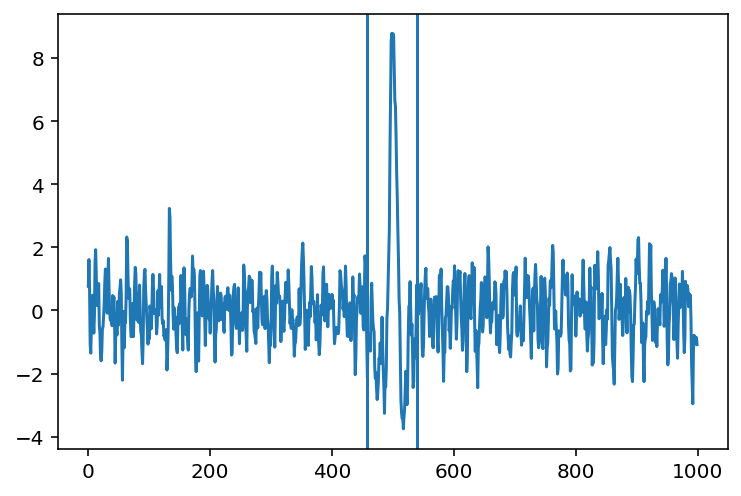

In [90]:
# Test find_vortices
vortices = mt.find_vortices(detection_threshold=2)
plt.plot(mt.convolution)
plt.axvline(mt.peak_indices[0] - 3.*mt.peak_widths[0])
plt.axvline(mt.peak_indices[0] + 3.*mt.peak_widths[0])

# Make sure the max peak in the convolution is the right one
assert(mt.time[mt.peak_indices[0]] < Gamma)

459 537
498 13
459.0 537.0


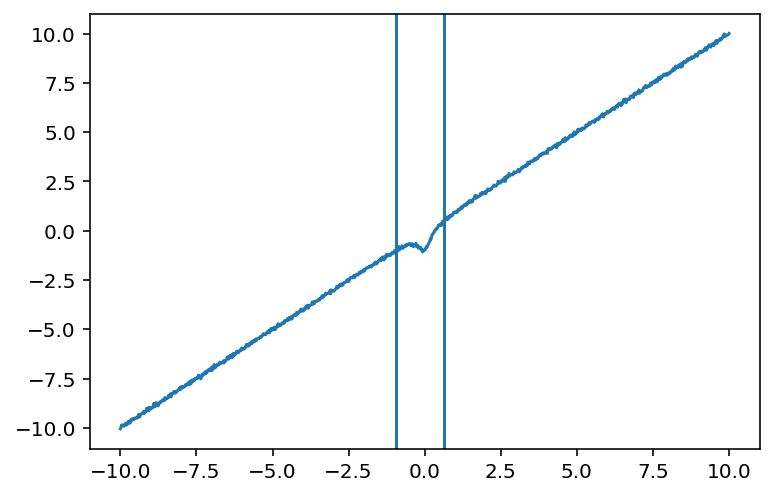

In [91]:
# Test find_vortices
vortices = mt.find_vortices(detection_threshold=7)
plt.plot(mt.time, mt.pressure)
print(mt.peak_indices[0], int(mt.peak_widths[0]))
plt.axvline(mt.time[peak_indices[0] - 3*int(mt.peak_widths[0])])
plt.axvline(mt.time[peak_indices[0] + 3*int(mt.peak_widths[0])])
print(mt.peak_indices[0] - 6/2*int(mt.peak_widths[0]), 
      mt.peak_indices[0] + 6/2*int(mt.peak_widths[0]))

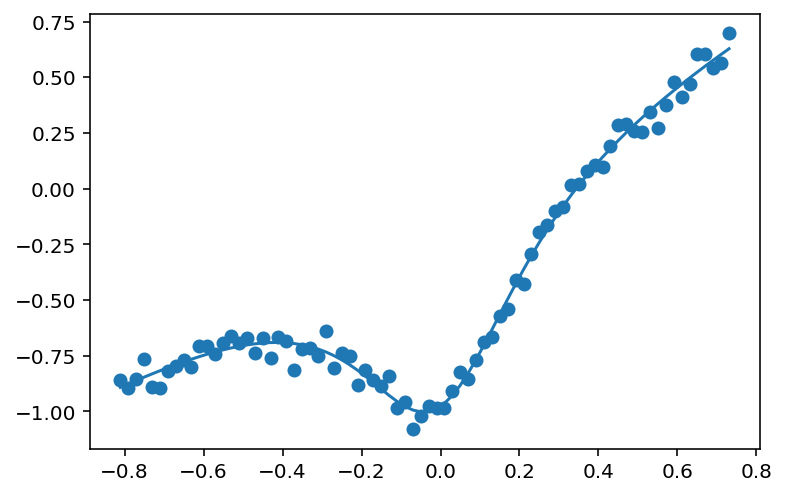

In [107]:
plt.scatter(vortices[0]["time"], vortices[0]["pressure"])

# baseline, slope, initial central time, initial delta P, and initial duration
popt, unc = fit_vortex(vortices[0], [0., 1., 0., 1., 0.01], 
                          [[-1, -1, np.min(vortices[0]["time"]), 0, 0],
                           [1, 1, np.max(vortices[0]["time"]), 2, 1]])

plt.plot(vortices[0]["time"], modified_lorentzian(vortices[0]["time"], *popt))

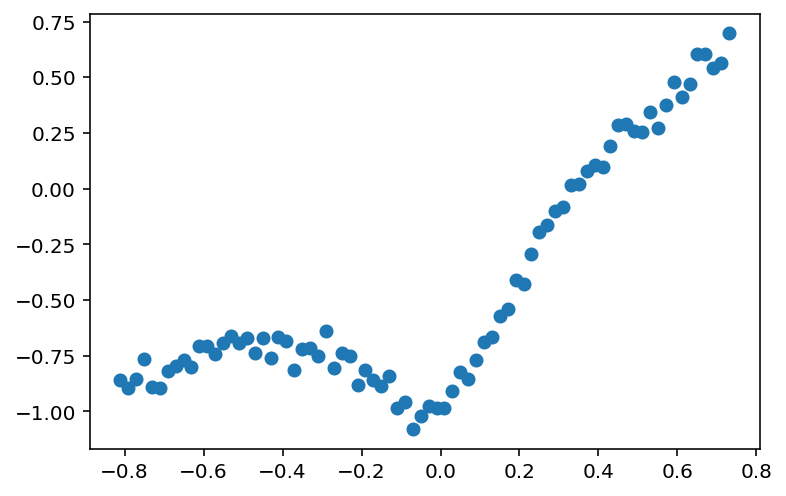

In [92]:
plt.scatter(vortices[0]["time"], vortices[0]["pressure"])

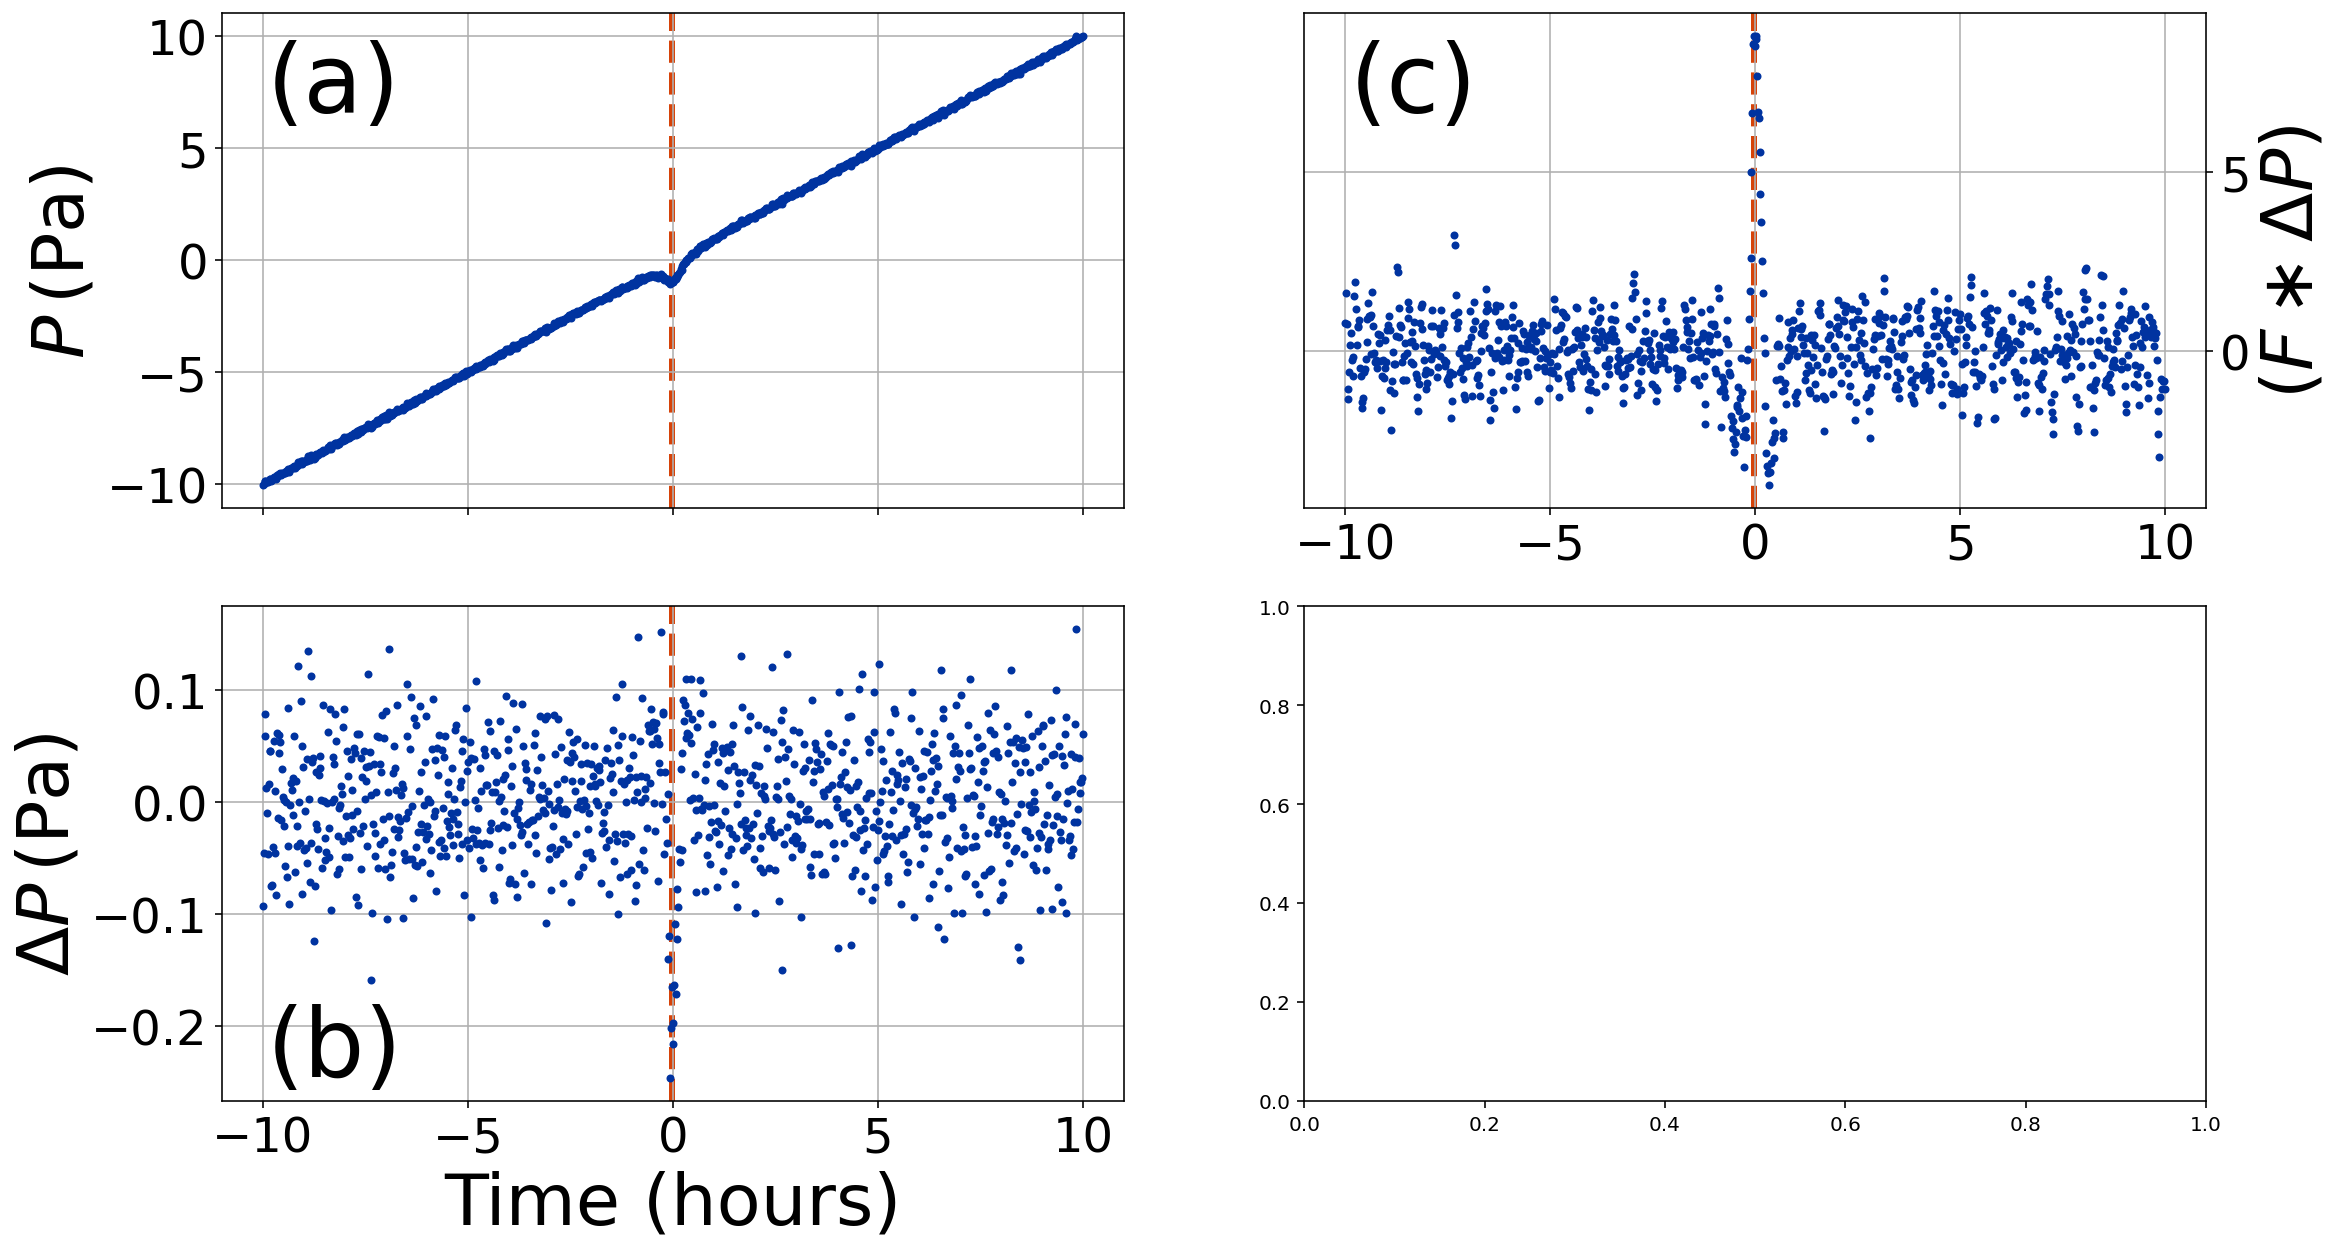

In [93]:
mt.make_conditioned_data_figure();